<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Data Mining and Machine Learning </p>
<p style="margin: 0; text-align:right;">2019 · Master in Data science</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Sara Estravís Nieto</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# SC Brain Matrix Classification

<ul>
  <li><a href='#dataload'>Data load</a></li>
  <li><a href='#knn'>K-NN</a></li>
  <li><a href='#svm'>SVM</a></li>
  <li><a href='#randomforest'>Random Forest</a></li>
</ul>

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from sklearn.svm import SVC
from sklearn.utils import shuffle
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

<a id = 'dataload'/>

## Data Load

In [2]:
# Load the csv brain data with the significant variables
data = pd.read_csv("SCMatrixSignificantData.csv") 

# Shuffle the data
data = shuffle(data, random_state=0).reset_index(drop=True)
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column174,Column175,Column176,Column177,Column178,Column179,Column180,Column181,Column182,Column183
0,2.396691,0.730968,2.552197,2.004677,1.015855,2.887735,4.912143,2.828218,6.304574,2.813657,...,4.026316,3.276316,4.065789,4.118421,3.171053,3.789474,4.697368,4.210526,5.671053,ms
1,1.970488,0.870745,1.433552,1.509425,1.009835,2.986910,4.820047,3.229880,6.390793,2.672527,...,3.473684,3.276316,4.065789,4.000000,3.144737,3.236842,4.815789,4.486842,5.789474,ms
2,1.794219,0.675071,1.485171,1.260655,0.866268,2.727176,3.713670,2.329179,4.672959,2.302637,...,3.592105,3.697368,3.986842,4.026316,3.065789,3.473684,4.421053,3.750000,5.394737,ms
3,1.877490,0.921275,1.654040,1.283696,1.114773,3.108576,4.547035,2.834067,5.477964,2.243947,...,3.276316,2.750000,3.828947,3.855263,2.934211,3.881579,3.842105,4.210526,4.815789,ms
4,2.429446,0.935277,2.181281,2.028645,1.279855,3.604746,5.435105,3.779656,6.918349,3.351619,...,3.263158,3.526316,3.986842,4.000000,3.052632,2.776316,4.197368,3.526316,5.171053,ms


In [3]:
# Separate the dataframe into nodes_properties (x) and classes (y)
nodes_properties = data.iloc[:,0:len(data.columns)-1]
print('Properties dimensions: ', nodes_properties.shape)

classes = data.iloc[:,len(data.columns)-1]
classes_names = ["hv", "ms"]
n_classes = len(classes_names)
print('Classes dimensions: ', classes.shape)
print('There are {} classes: {}'.format(n_classes, classes_names))

Properties dimensions:  (239, 182)
Classes dimensions:  (239,)
There are 2 classes: ['hv', 'ms']


In [4]:
# Divide the dataframe in the test and train sets, with 80% of the data in the train group and 20% in the test set.
# We will stratify using classes, so that there is the same proportion of each class in the test/train sets as in the original
# dataset
X_train, X_test, y_train, y_test = train_test_split(nodes_properties, classes, test_size=0.2, random_state=2019, stratify=classes)


In [5]:
print('X_train dimensions: ', X_train.shape)
print('y_train dimensions: ', y_train.shape)

print('X_test dimensions: ', X_test.shape)
print('y_test dimensions: ', y_test.shape)

X_train dimensions:  (191, 182)
y_train dimensions:  (191,)
X_test dimensions:  (48, 182)
y_test dimensions:  (48,)


<a id='knn'></a>

## K-NN

#### Hyperparameter tuning

In [6]:
# First of all, create the classifier
knn = KNeighborsClassifier()

# Then, the hyperparameters to be optimized are defined 
# k = number of nearest neighbours considered
# weights = weight function used in prediction. If it is 'uniform', all the neighbours will have the same importance. If it is 
# 'distance', closer neighbours will have more influence. 

k_range = list(range(1, 21))
weight_names = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights = weight_names)

# Now create the grid search with 4 folds for cross-validation
grid = GridSearchCV(knn, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 2.9245636463165283 seconds
 
Rank : 1. Mean accuracy 80.1086 +/- 3.0964. Parameters: {'n_neighbors': 20, 'weights': 'distance'}


#### Model training with best parameters

In [7]:
# First create and fit the model with the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=grid.best_params_["n_neighbors"], weights=grid.best_params_["weights"])

knn.fit(X_train, y_train)

# Predict the test values
y_predicted = knn.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("K-NN Algorithm results")
print("-----------------------")
print("Optimal k: {}".format(grid.best_params_["n_neighbors"]))
print("Optimal weights: {}".format(grid.best_params_["weights"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

K-NN Algorithm results
-----------------------
Optimal k: 20
Optimal weights: distance
Accuracy in the test set with the optimal parameters: 83.33%


In [8]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Confusion matrix

[[ 1  8]
 [ 0 39]]


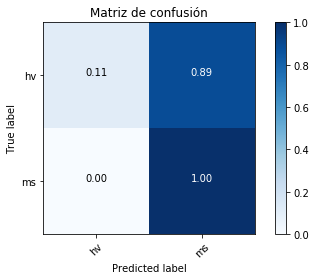

In [9]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

<a id='svm'></a>

## SVM

 #### Hyperparameter tuning

In [10]:
# Create the classifier
svm_clasif = SVC(random_state = 1)

# Define the hyperparameters to be optimized
param_dist = dict(C=uniform(1, 100), gamma=uniform(0.001, 1))

# Now create the randomnized search with 4 folds for cross-validation
num_iterations = 100
cv = StratifiedKFold(n_splits=4, shuffle=True)
rand = RandomizedSearchCV(svm_clasif, param_distributions = param_dist, cv=cv, n_iter=num_iterations)

# Apply the search to the data checking the time 
start = time()
rand.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(rand.cv_results_['rank_test_score'])
means = list(rand.cv_results_["mean_test_score"])
stds = list(rand.cv_results_["std_test_score"])
params = list(rand.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))

The search took 8.248735904693604 seconds
 
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 100.28345798781999, 'gamma': 0.24008373343618805}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 88.20243240140378, 'gamma': 0.6979540840107857}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 93.17164885941706, 'gamma': 0.6538227530432293}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 38.43565233577334, 'gamma': 0.12992277199756075}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 47.47552859002953, 'gamma': 0.5953571654291061}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 50.55620751856632, 'gamma': 0.012155530427836347}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 33.56404559307131, 'gamma': 0.9888755319017545}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 35.25065060396698, 'gamma': 0.6054799798296193}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 10.225141

#### Train model with best parameters

In [11]:
# Create and fit the model with the best hyperparameters
svm_clasif = SVC(C=rand.best_params_["C"], gamma=rand.best_params_["gamma"])
svm_clasif.fit(X_train, y_train)

# Predict the test values
y_predicted = svm_clasif.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("SVM Algorithm results")
print("-----------------------")
print("Optimal C: {}".format(rand.best_params_["C"]))
print("Optimal gamma: {}".format(rand.best_params_["gamma"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

SVM Algorithm results
-----------------------
Optimal C: 100.28345798781999
Optimal gamma: 0.24008373343618805
Accuracy in the test set with the optimal parameters: 81.25%


#### Confusion matrix

[[ 0  9]
 [ 0 39]]


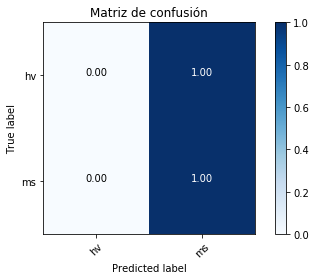

In [12]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

<a id='randomforest'></a>

## Random Forest

#### Hyperparameter tuning

In [13]:
# Create the classifier
random_forest = RandomForestClassifier(random_state=0)

# Define the hyperparameters to be optimized 
n_estimators = list(range(1, 61))
max_depth = range(1, 100, 10)

param_grid = dict(n_estimators=n_estimators, max_depth = max_depth)

# Create the grid search with 4 folds for cross-validation
grid = GridSearchCV(random_forest, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 122.03399801254272 seconds
 
Rank : 1. Mean accuracy 81.6711 +/- 1.7657. Parameters: {'max_depth': 1, 'n_estimators': 3}
Rank : 1. Mean accuracy 81.6711 +/- 0.9734. Parameters: {'max_depth': 1, 'n_estimators': 9}
Rank : 1. Mean accuracy 81.6711 +/- 0.9734. Parameters: {'max_depth': 1, 'n_estimators': 10}


#### Train model with best hyperparameters

In [14]:
# Create and fit the model with the best hyperparameters
random_forest = RandomForestClassifier(random_state=0, n_estimators=grid.best_params_["n_estimators"], max_depth=grid.best_params_["max_depth"])
random_forest.fit(X_train, y_train)

# Predict the test values
y_predicted = random_forest.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("Random Forest Algorithm results")
print("-----------------------")
print("Optimal n_estimators: {}".format(grid.best_params_["n_estimators"]))
print("Optimal max_depth: {}".format(grid.best_params_["max_depth"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

Random Forest Algorithm results
-----------------------
Optimal n_estimators: 3
Optimal max_depth: 1
Accuracy in the test set with the optimal parameters: 81.25%


#### Confusion Matrix

[[ 0  9]
 [ 0 39]]


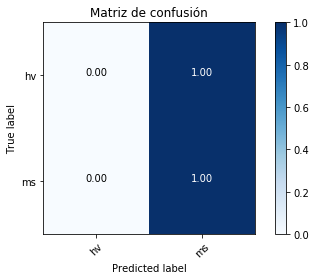

In [15]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')